# Transformer model
![](./transformer.png)

# This is quite important for practice in ML/DL model building, always start from a sample set from the large data set.


- In Transformer models for NLP tasks, the data goes through several stages with specific dimensionalities at each stage. Here's a breakdown of the typical data dimension constructions:

  **1. Input Text:**

  - **Batch Size (B):** This represents the number of sentences processed together in a single training or inference step. It's common to use mini-batches to improve training efficiency.
  - **Sequence Length (S):** This is the number of words or tokens in a sentence. The maximum sequence length might be limited due to computational constraints.

  **2. Word Embeddings (E):**

  - Words in the input sentence are converted into dense numerical vectors using a pre-trained word embedding model (e.g., Word2Vec, GloVe).

  - The embedding dimension (E) is typically a hyperparameter, commonly ranging from 50 to 300.

  - Resultant Dimension:

     (B, S, E) - This represents a 3D tensor where:

    - B: Batch size
    - S: Sequence length
    - E: Embedding dimension (e.g., a 100-dimensional vector for each word)

  **3. Positional Encoding (PE):**

  - Transformer models lack inherent knowledge about the order of words in a sentence.
  - Positional encoding (PE) vectors are added to the word embeddings to incorporate positional information.
  - The PE vectors have the same dimension (E) as the word embeddings.
  - **Resultant Dimension:** (B, S, E) - The original embedding dimension (B, S, E) is preserved after adding the positional encoding vectors element-wise.

  **4. Padding (Optional):**

  - Sequences can have varying lengths. To enable batch processing, shorter sequences are padded with special tokens (e.g., PAD token) up to a predefined maximum length.
  - The padding tokens typically have their own embedding vectors.
  - **Resultant Dimension:** (B, S_max, E) - The dimension is extended to the maximum sequence length (S_max) to accommodate sequences of different lengths.

  **5. Transformer Input (d_model):**

  - The Transformer input is the sum of the word embeddings and positional encodings.
  - d_model represents the final dimension of the Transformer input after adding these two components. It's a hyperparameter often set to be the same as the word embedding dimension (E) for simplicity.
  - **Resultant Dimension:** (B, S_max, d_model)

  **6. Multi-Head Attention:**

  - Within the Transformer architecture, the multi-head attention mechanism operates on the input with dimension (B, S_max, d_model).
  - The number of heads (h) is another hyperparameter in the Transformer.
  - The attention mechanism projects the input into separate query, key, and value vectors, each with a dimension of (d_model // h). These projections are then used to calculate attention scores and weighted sums.
  - **Internal Attention Calculations:** The dimensions might change within the attention sub-layers, but ultimately, the output retains the shape of the input (B, S_max, d_model).

  **7. Transformer Encoder/Decoder Layers:**

  - The Transformer typically consists of multiple encoder and/or decoder layers depending on the specific NLP task (e.g., machine translation uses both encoders and decoders).
  - Each encoder/decoder layer takes the output from the previous layer (which has dimension B, S_max, d_model) as input and applies several linear transformations, attention mechanisms, and residual connections.
  - The dimension (B, S_max, d_model) is usually preserved throughout these layers to maintain compatibility between layers.

  **8. Output Layer:**

  - The final output layer of the Transformer depends on the task.
    - In machine translation, it might project the output from the final encoder/decoder layer (B, S_max, d_model) to the vocabulary size to predict the next word in the target language.
    - In sentiment analysis, it might use a final linear layer to classify the sentiment (positive, negative, neutral) based on the final encoder output (B, S_max, d_model).

  **Key Points:**

  - Batch size (B) and sequence length (S) can vary depending on the dataset and computational resources.
  - Embedding dimension (E) and d_model are hyperparameters typically chosen based on the task and dataset characteristics.
  - The multi-head attention mechanism operates on slices of the input with dimension (B, S_max, d_model).
  - Transformer encoder/decoder layers often preserve the dimension (B, S_max, d_model) for compatibility between layers.

  Understanding these data dimensionalities is crucial for effectively working with Transformer models in NLP tasks.

In [119]:
import os
import math
import copy
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import jieba
import nltk
from nltk import word_tokenize
from collections import Counter
from torch.autograd import Variable

import seaborn as sns
import matplotlib.pyplot as plt

In [120]:
# NLTK resource https://www.nltk.org/data.html
# Download resources for part-of-speech tagging
nltk.download('averaged_perceptron_tagger')

# Download WordNet resources (for tasks like synonym extraction)
nltk.download('nltk_data/corpora/wordnet')

# Download Open Multilingual WordNet resource
nltk.download('nltk_data/corpora/omw-1.4')

# Download pre-trained model for sentence tokenization (especially for English)
nltk.download('punkt')


#################### Corpora ###############################
# Download the Brown Corpus
nltk.download('brown')

# Download a collection of English texts from Project Gutenberg
nltk.download('gutenberg')

# Download other corpora (replace names with desired ones)
nltk.download('shakespeare')
nltk.download('cmudict')
nltk.download('cess_cat')

############## Stop words ######################################
# Download stopwords for a specific language (replace 'english' with the code)
nltk.download('stopwords/english')

# Download stopwords for other languages (e.g., 'french', 'german')
nltk.download('stopwords/<language_name>')

############ Additional resource#################
# Download gazetteers (geographical name lists)
nltk.download('gazetteers')

# Download names (personal name lists)
nltk.download('names')

# Download data for Snowball stemmers
nltk.download('snowball_data')

# Download Wall Street Journal parsed corpus (for advanced tasks)
nltk.download('treebank')

# Download sample tweets from Twitter
nltk.download('twitter_samples')




[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/loveplay1983/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Error loading nltk_data/corpora/wordnet: Package
[nltk_data]     'nltk_data/corpora/wordnet' not found in index
[nltk_data] Error loading nltk_data/corpora/omw-1.4: Package
[nltk_data]     'nltk_data/corpora/omw-1.4' not found in index
[nltk_data] Downloading package punkt to
[nltk_data]     /home/loveplay1983/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /home/loveplay1983/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/loveplay1983/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     /home/loveplay1983/nltk_data...
[nltk_data]   Package shakes

True

In [ ]:
# #  Init parameters

# UNK = 0 # unknow word-id
# PAD = 1 # padding word-id
# BATCH_SIZE = 64

# DEBUG = False
# # DEBUG = False # model building, GPU CUDA is preferred

# if DEBUG:
#     EPOCHS = 2
#     LAYERS = 3
#     H_NUM = 8
#     D_MODEL = 128
#     D_FF = 256
#     DROPOUT = 0.1
#     MAX_LENGTH = 60
#     TRAIN_FILE = "./data/nmt/en-cn/train_mini.txt"
#     DEV_FILE = "./data/nmt/en-cn/dev_mini.txt"
#     SAVE_FILE = "./save/models/model.pt"

# else:
#     EPOCHS = 20
#     LAYERS = 6
#     H_NUM = 8
#     D_MODEL = 256
#     D_FF = 1024
#     DROPUT = .1
#     MAX_LENGTH = 60
#     TRAIN_FILE = "./data/nmt/en-cn/train.txt"
#     DEV_FILE = "./data/nmt/en-cn/dev.txt"
#     SAVE_FILE = "./save/models/large_model.pt"

# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [191]:
#  Init parameters

UNK = 0 # unknow word-id
PAD = 1 # padding word-id
BATCH_SIZE = 64

DEBUG = False
# DEBUG = False # model building, GPU CUDA is preferred

if DEBUG:
    EPOCHS = 2
    LAYERS = 3
    H_NUM = 8
    D_MODEL = 128
    D_FF = 256
    DROPOUT = 0.1
    MAX_LENGTH = 60
    TRAIN_FILE = "./data/nmt/en-cn/train_mini.txt"
    DEV_FILE = "./data/nmt/en-cn/dev_mini.txt"
    SAVE_FILE = "./save/models/model.pt"

else:
    EPOCHS = 60
    LAYERS = 12
    H_NUM = 8
    D_MODEL = 256
    D_FF = 1024
    DROPUT = .1
    MAX_LENGTH = 60
    TRAIN_FILE = "./data/nmt/en-cn/train.txt"
    DEV_FILE = "./data/nmt/en-cn/dev.txt"
    SAVE_FILE = "./save/models/large_model.pt"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Util functions and classes

In [122]:
def clones(module, N):
    """
    Produce N identical layers
    Use deepcopy the weight are indenpendent
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# 1.  Decoder input excludes the last dim - EOS
The decoder predicts the target language sentence one word at a time.
The "BOS" token provides initial context for the decoder, indicating the start of the sentence.
The decoder doesn't need the "EOS" token for prediction, as it can inherently stop generating words when it reaches a certain length or encounters a padding token.

# 2. Decoder target excludes the first dim - BOS
Similar to `self.trg`, `trg` represents the entire target language sentence.
`[:, 1:]` selects all rows (`[:,`) and excludes the **first column** (`1:`).
This assigns the **decoder target** (ground truth) to `self.trg_y`.
**Excludes BOS:**
- The slicing operation excludes the first column, which is the "BOS" token.
- The decoder target represents the actual words the decoder aims to predict.

____

- **Training Process:**

  1. **Encoder Processes Source Language:**
     - The source language sentence (`src`) is fed into the encoder.
     - The encoder generates a representation (often a context vector) that captures the meaning and structure of the source language.
  2. **Decoder Gets Encoder Output and Decoder Input:**
     - The decoder receives two key inputs:
       - **Encoder Output:** This compressed representation from the encoder provides essential context about the source language sentence.
       - **Decoder Input (trg[:, :-1])** : This portion of the target language sentence (excluding the last word, "EOS") acts as a starting point for the decoder's prediction process.
  3. **Decoder Predicts Target Words:**
     - Using the encoder output and the initial decoder input (one word), the decoder attempts to predict the next word in the target language sequence.
     - This prediction process continues one word at a time, with the decoder's previous prediction feeding into the next step.
  4. **Comparison with Decoder Target:**
     - After predicting the entire target language sentence (or reaching a maximum length/padding), the model compares the predicted sequence with the actual target sequence (`trg[:, 1:]`, excluding the first word, "BOS").
     - This comparison is used to calculate the loss (difference between prediction and ground truth).
  5. **Model Learns and Improves:**
     - Based on the calculated loss, the model adjusts its internal parameters (weights and biases) through an optimizer algorithm.
     - This training process iterates over many source-target language pairs, allowing the decoder to learn how to translate from the source language to the target language effectively.

  **Key Point:**

  - The decoder input, which excludes the EOS token, provides a starting point for the decoder's prediction process while leveraging the encoder's output for context.
  - This setup enables the model to learn how to generate the target language sentence one word at a time, guided by the context from the source language and the previously predicted words in the target sequence.

  **Additional Notes:**

  - Some models might use additional mechanisms like attention to focus on specific parts of the encoder output while generating each word in the target sequence.
  - The specific details of the encoder, decoder, and attention mechanism can vary depending on the model architecture.

In [123]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        # convert words id to long format.  
        src = torch.from_numpy(src).to(DEVICE).long()
        trg = torch.from_numpy(trg).to(DEVICE).long()
        self.src = src
        # get the padding postion binary mask
        # change the matrix shape to  1×seq.length
        self.src_mask = (src != pad).unsqueeze(-2)
        # 如果输出目标不为空，则需要对decoder要使用到的target句子进行mask
        if trg is not None:
            # decoder input from target 
            self.trg = trg[:, :-1]
            # decoder target from trg 
            self.trg_y = trg[:, 1:]
            # add attention mask to decoder input  
            self.trg_mask = self.make_std_mask(self.trg, pad)
            # check decoder output padding number
            self.ntokens = (self.trg_y != pad).data.sum()
    
    # Mask 
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask # subsequent_mask is defined in 'decoder' section.

- **1. Creating Masks for Padding:**

  - In sequence-to-sequence models, sentences can have different lengths. Padding tokens are often added to shorter sentences to make them all the same length.
  - However, we don't want the attention mechanism to focus on padding tokens, as they don't carry meaning.

  **2. The Role of `src_mask` and `tgt_mask`:**

  - Both `src_mask` and `tgt_mask` are binary masks created from the source language data (`src`) and target language data (`tgt`), respectively.

  - They use the comparison 

    ```
    (src != pad)
    ```

     or 

    ```
    (tgt != pad)
    ```

     to achieve this:

    - Elements where the data (`src` or `tgt`) is not equal to the padding token (`pad`) become 1 (True), indicating they are valid elements to attend to.
    - Elements where the data is equal to the padding token (`pad`) become 0 (False), indicating they should be masked out during attention calculations.

  **3. The `unsqueeze(-2)` Operation:**

  - The `unsqueeze(-2)` operation inserts a new dimension of size 1 at the specified index (-2 refers to the second dimension from the end).

  **Why Unsqueeze? Dimensionality Matters:**

  - The necessity of 

    ```
    unsqueeze(-2)
    ```

     arises due to the potential difference in the dimensionality of the source and target data (

    ```
    src
    ```

     and 

    ```
    tgt
    ```

    ).

    - They could be 2D tensors (`[batch_size, sequence_length]`) or 3D tensors (`[batch_size, sequence_length, embedding_size]`), depending on the model architecture.
    - The attention mechanism typically operates on matrices (2D tensors) where one dimension represents the source sequence and the other represents the target sequence (or the source sequence itself in a self-attention setting).

  **How `unsqueeze(-2)` Helps:**

  - If `src` or `tgt` is a 2D tensor (`[batch_size, sequence_length]`), `unsqueeze(-2)` creates a 3D tensor (`[batch_size, 1, sequence_length]`), where the new dimension of size 1 is inserted before the sequence length dimension.
  - If `src` or `tgt` is already a 3D tensor (`[batch_size, sequence_length, embedding_size]`), `unsqueeze(-2)` creates a 4D tensor (`[batch_size, 1, sequence_length, embedding_size]`), where the new dimension of size 1 is inserted before the sequence length dimension.

  **Ensuring Compatibility:**

  - By adding this new dimension, `unsqueeze(-2)` ensures that the `src_mask` and `tgt_mask` have the correct dimensionality to be broadcastable with the source and target language data (`src` and `tgt`), respectively, during attention calculations.
  - This allows the masks to effectively apply masking (setting attention scores to zero) for padding tokens in both the source and target languages, regardless of their original dimensionality.

  **In essence:**

  - The code creates masks (`src_mask` and `tgt_mask`) using element-wise comparison with the padding token (`pad`).
  - The `unsqueeze(-2)` operation ensures these masks have the appropriate dimensionality to work correctly with the source and target language data during attention in the encoder and decoder, respectively.

# Variable method
```python
# Old PyTorch (using Variable)
output = Variable(model(input), requires_grad=False)  # Detach from graph
# New PyTorch
output = model(input).detach()  # Detach from graph
# Or
with torch.no_grad():
  output = model(input)  # Disable gradients within the block
```



**Combining Masks with AND:**

- When you perform the bitwise AND between these masks using $&$:
  - Only elements that are **not padding tokens** (1 in the first mask) **and** are **not future words** (0 in the second mask, inverted for AND) will remain unmasked (have a value of 1 in the final `tgt_mask`).
  - Essentially, the AND operation ensures that only elements that satisfy both masking conditions (not padding and not future) pass through the computation, effectively combining the functionality of both masks.
 
```python
tensor1 = torch.tensor([1, 0, 1])  # Binary: [0001, 0000, 0001] (Not padding)
tensor2 = torch.tensor([0, 1, 0])  # Binary: [0000, 0001, 0000] (Future words)
result = tensor1 & tensor2
print(result)
```

# Data Preprocessing 
1. Load the sentence and tokenize the sentence and add start/end marks(Begin of Sentence /End of Sentence vs BOS/ EOS).
2. Build dictionaries including ‘word-to-id’ and inverted dictionary ‘id-to-word’: English and Chinese, ‘word: index}, i.e, {‘english’: 1234}, {1234: ‘english’}.
3. Sort the dictionaries to reduce padding.
4. Split the dataset into patches for training and validation.

In [124]:
def seq_padding(X, padding=0):
    """
    Add padding to a batch of data
    """
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([
        np.concatenate([
            x, [padding] * (ML - len(x))
        ]) if len(x) < ML else x for x in X
    ])

In [125]:
class PrepareData:
    def __init__(self, train_file, dev_file):
        # 1. Read the data and tokenize
        self.train_en, self.train_cn = self.load_data(train_file)
        self.dev_en, self.dev_cn = self.load_data(dev_file)

        # 2. build dictionary: En and CN
        self.en_word_dict, self.en_total_words, self.en_index_dict = self.build_dict(self.train_en)
        self.cn_word_dict, self.cn_total_words, self.cn_index_dict = self.build_dict(self.train_cn)

        # 3. word to id by dictionary
        self.train_en, self.train_cn = self.wordToID(self.train_en, self.train_cn, 
                                                     self.en_word_dict, self.cn_word_dict)
        self.dev_en, self.dev_cn = self.wordToID(self.dev_en, self.dev_cn, 
                                                 self.en_word_dict, self.cn_word_dict)

        # 4. batch, padding, and masking
        self.train_data = self.splitBatch(self.train_en, self.train_cn, BATCH_SIZE)
        self.dev_data = self.splitBatch(self.dev_en, self.dev_cn, BATCH_SIZE)

    # Utility functions
    def load_data(self, path):
        """
        read data, tokenize the seence and add start and end marks(bos, eos)
        for example:
        en = [
            ["BOS", "i", "love", "you", "EOS"],
            ["BOS", "me", "too", "EOS"],
            ...
        ]
        cn = [
            ["BOS", "我", "爱", "你", "EOS"],
            ["BOS", "我", "也", ,"是", "EOS"],
            ...
        ]
        """
        en = []
        cn = []
        with open(path, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip().split("\t")
                en.append(["BOS"] + word_tokenize(line[0].lower()) + ["EOS"])
                cn.append(["BOS"] + word_tokenize(" ".join([w for w in line[1]])) + ["EOS"])
        return en, cn
    
    def build_dict(self, sentences, max_words = 50000):
        """
        sentences: list of word list
        build dictionary as {key(word): value(id)}
        """
        word_count = Counter()
        for sentence in sentences:
            for s in sentence:
                word_count[s] += 1
                
        ls = word_count.most_common(max_words)
        total_words = len(ls) + 2 # BOS + EOS = 2
        word_dict = {w[0]: index + 2  for index, w in enumerate(ls)}
        word_dict["UNK"] = UNK
        word_dict["PAD"] = PAD
        # inverted index:  {key(id): value(word)}
        index_dict = {v: k for k, v in word_dict.items()}
        return word_dict, total_words, index_dict
        
        
    def wordToID(self, en, cn, en_dict, cn_dict, sort=True):
        """
        convert input/output word lists to id lists
        use input word list length to sort, reduce padding
        """
        length = len(en)
        out_en_ids = [[en_dict.get(w, 0) for w in sent] for sent in en]
        out_cn_ids = [[cn_dict.get(w, 0) for w in sent] for sent in cn]
        
        def len_argsort(seq):
            """
            get sorted index w.r.t length.
            """
            
            return sorted(range(len(seq)), key=lambda x: len(seq[x]))
        
        if sort:
            sorted_index = len_argsort(out_en_ids) # English
            out_en_ids = [out_en_ids[id] for id in sorted_index]
            out_cn_ids = [out_cn_ids[id] for id in sorted_index]
            
        return out_en_ids, out_cn_ids
    
    def splitBatch(self, en, cn, batch_size, shuffle=True):
        """
        get data into batches
        """
        idx_list = np.arange(0, len(en), batch_size) # start, stop, step
        if shuffle:
            np.random.shuffle(idx_list)

        batch_indexs = []
        for idx in idx_list:
            # batch index between current index and the min index o
            batch_indexs.append(np.arange(idx, min(idx+batch_size, len(en)))) 

        batches = []
        for batch_index in batch_indexs:
            batch_en = [en[index] for index in batch_index]
            batch_cn = [cn[index] for index in batch_index]
            # paddings: batch, batch_size, batch_maxlen
            batch_cn = seq_padding(batch_cn)
            batch_en = seq_padding(batch_en)
            # Batch class will be defined later which is the masking batch of data during training
            # "Object for holding a batch of data with mask during training."
            batches.append(Batch(batch_en, batch_cn)) 
            
        return batches

In [126]:
# class Batch:
#     "Object for holding a batch of data with mask during training."
#     def __init__(self, src, trg=None, pad=0):
#         # convert words id to long format.  
#         src = torch.from_numpy(src).to(DEVICE).long()
#         trg = torch.from_numpy(trg).to(DEVICE).long()
#         self.src = src
#         # get the padding postion binary mask
#         # change the matrix shape to  1×seq.length
#         self.src_mask = (src != pad).unsqueeze(-2)
#         # 如果输出目标不为空，则需要对decoder要使用到的target句子进行mask
#         if trg is not None:
#             # decoder input from target 
#             self.trg = trg[:, :-1]
#             # decoder target from trg 
#             self.trg_y = trg[:, 1:]
#             # add attention mask to decoder input  
#             self.trg_mask = self.make_std_mask(self.trg, pad)
#             # check decoder output padding number
#             self.ntokens = (self.trg_y != pad).data.sum()
    
#     # Mask 
#     @staticmethod
#     def make_std_mask(tgt, pad):
#         "Create a mask to hide padding and future words."
#         tgt_mask = (tgt != pad).unsqueeze(-2)
#         tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
#         return tgt_mask # subsequent_mask is defined in 'decoder' section.

Understanding Initialization:

When you create an nn.Embedding layer, it initializes a lookup table with random embedding vectors for each word in the vocabulary.
These initial vectors have a specific dimensionality (d_model) but their values are randomly chosen within a certain range.
Normalization and Gradient Vanishing:

Without the math.sqrt(d_model) factor, the initial values of the embedding vectors can have a large magnitude (very high or very low values).
This can lead to two potential issues:
Normalization: If the initial values have a large magnitude, the gradients during training might become very small when backpropagated through the network. This is known as the vanishing gradient problem, which can hinder the learning process.
Activation Functions: If the network uses activation functions with bounded outputs (like sigmoid or tanh), large initial values can cause these activations to saturate, effectively making them insensitive to further changes.
The Role of math.sqrt(d_model):

Multiplying the embedding vectors by math.sqrt(d_model) essentially scales their initial values. This scaling helps address the issues mentioned above:
Normalization: By dividing the variance of the initial values by d_model, the gradients tend to have a more manageable magnitude during backpropagation, improving learning efficiency.
Activation Functions: Scaling the initial values ensures they are within a range where activation functions can operate effectively, allowing for more nuanced gradients during training.
Alternative Initializations:

While math.sqrt(d_model) is a common scaling factor, it's not the only approach. Some researchers use other techniques like uniform initialization within a specific range or initialization based on pre-trained word embeddings from sources like Word2Vec or GloVe.

In [127]:
# input and output embeddngs
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        # lut -> lookup table
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        # return x's embedding vector (times math.sqrt(d_model))
        return self.lut(x) * math.sqrt(self.d_model)

# Positional encoding
[max_sequence_len, embedding_dim] 
$$PE_{(pos, 2i)} = sin(\frac{pos}{10000^{2i/d_{model}}})$$
$$PE_{(pos, 2i+1)} = cos(\frac{pos}{10000^{2i/d_{model}}})$$

**1. Standard Formula and Scaling Factor:**

The standard formula for positional encoding in Transformers defines a scaling factor that influences the influence of position on the final embedding:

```
PE(pos, 2i) = sin(pos * 10000.0^(2i / d_model))
PE(pos, 2i + 1) = cos(pos * 10000.0^(2i / d_model))
```

Here, the key term is `10000.0^(2i / d_model)`. Raising 10000.0 to a power that decreases with position (`i`) (due to the division by `d_model`) creates a scaling effect:

- For positions closer to zero (smaller `i`), the value is closer to 10000.0, giving the position a stronger influence.
- As the position (`i`) increases, the power term gets smaller, reducing the influence of position on the sine or cosine function.

**2. Code and Its Scaling Effect:**

The code snippet calculates a component for the positional encoding, focusing on even positions (`i`):

```
torch.exp(torch.arange(0., d_model, 2, device=DEVICE) * -(math.log(10000.0) / d_model))
```

This code achieves a similar scaling effect as the standard formula, but using logarithms:

- `torch.exp(...)`: Applies the exponential function (e raised to the power of...).
- `torch.arange(0., d_model, 2, device=DEVICE)`: Creates a sequence of increasing values for even positions.
- `- (math.log(10000.0) / d_model)`: A constant term calculated as the negative logarithm of 10000.0 divided by `d_model`. The negative sign ensures the base of the exponential term is less than 1, creating a decaying sequence.

**3. The Connection:**

Here's why the code achieves a similar effect:

- **Decaying Sequence:** The exponential term (`torch.exp(...)`) with the negative scaling factor creates a sequence of values that decay as the position (`i`) increases in the `torch.arange` part. This mimics the decreasing power term in the standard formula.
- **Scaling Factor and Logarithm:** The constant term `- (math.log(10000.0) / d_model)` plays a crucial role. Let's analyze it:
  - `math.log(10000.0)`: This calculates the natural logarithm (base e) of 10000.0. A larger value like 10000.0 in the logarithm typically results in a value close to 4 (logarithm of 10000 to base e is approximately 4.6).
  - `- (...)`: The negative sign flips the result, ensuring the base of the exponential term in `torch.exp` is less than 1.
  - `/ d_model`: This division scales the effect based on the model's dimension (`d_model`).

**Essentially, raising `e` (base of the natural logarithm) to the power of `- (math.log(10000.0) / d_model)` results in a value close to 1/(10000.0^1), scaled by `d_model`. This acts similarly to the inverse of the scaling factor in the standard formula.**

**In simpler terms:**

- The standard formula uses `10000.0` raised to a power that decreases with position (`i`) to create a scaling effect.
- The code achieves a similar effect by taking the inverse logarithm of 10000.0, dividing by `d_model`, and using that as the base of a decaying exponential term. The final result is mathematically equivalent (or very close) to the inverse of the scaling factor in the standard formula.

**Deriving the Formula:**

While the code doesn't directly calculate the inverse of the standard formula's scaling factor, it achieves a functionally equivalent outcome. Here's a breakdown of the steps involved:

1. Standard Formula Scaling Factor:
   - `10000.0^(2i / d_model)` (this term controls the influence of position in the standard formula).
2. Code's Scaling Effect:
   - The negative logarithm term (`-math.log(10000.0)`) in the code roughly scales the values down to

In [128]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model, device=DEVICE)
        position=torch.arange(0., max_len, device=DEVICE).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2, 
                                          device=DEVICE) * -(math.log(10000.0) / d_model))
        pe_pos = torch.mul(position, div_term)
        # [start:stop:step]  - 0::2 start from 0 stop at each 2 steps
        #                    - 1::2 start from 1 stop at each 2 steps
        pe[:, 0::2] = torch.sin(pe_pos)  # even embedding dimension
        pe[:, 1::2] = torch.cos(pe_pos)  # odd  embedding dimension
        pe = pe.unsqueeze(0)
        
        self.register_buffer("pe", pe)  # pe
        
    def forward(self, x):
        # build pe w.r.t to the max_len
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

**`register_buffer` vs. Parameters:**

- **`register_buffer`:**
  - `Used` to store a tensor as a **buffer**.
  - Buffers **do not** have gradients calculated during backpropagation. Their values remain constant throughout training.
  - Useful for storing precomputed values, lookup tables, or other tensors that don't require updates based on the loss function.
- **Parameters:**
  - Learnable weights and biases within a module.
  - Gradients are calculated during backpropagation based on the loss function.
  - Updated through optimization algorithms (like SGD or Adam) to improve the model's performance.
  
  
___
  - `pe` is a precomputed positional encoding tensor. Its values are calculated based on the embedding dimension (`d_model`) and maximum sequence length (`max_len`) and don't change during training.
- `self.register_buffer("pe", pe)` stores this tensor within the module as a named buffer (`pe`).
- <u>Since it's a buffer, the gradients for `pe` are not tracked. This is because the positional encoding values are already determined and shouldn't be updated based on the loss function.</u>

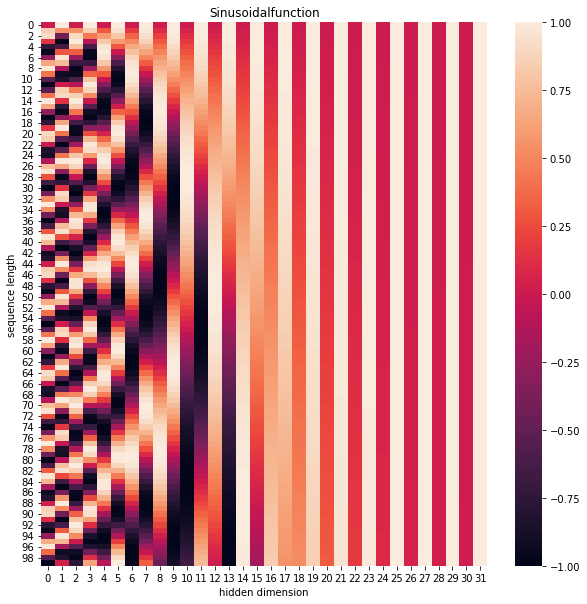

In [129]:
pe = PositionalEncoding(32, 0, 100)  # d_model, dropout-ratio, max_len
positional_encoding = pe.forward(Variable(torch.zeros(1, 100, 32, device=DEVICE))) # sequence length, d_model
plt.figure(figsize=(10, 10))
sns.heatmap(positional_encoding.squeeze().cpu()) # 100*32 matrix
plt.title("Sinusoidalfunction")
plt.xlabel("hidden dimension")
plt.ylabel("sequence length")
None

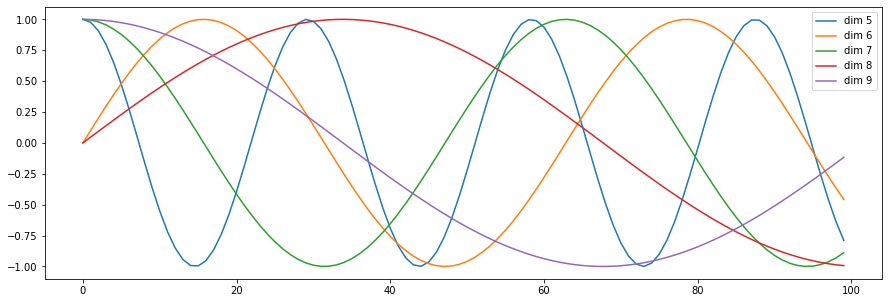

In [130]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(24, 0)
y = pe.forward(torch.zeros(1, 100, 24, device=DEVICE))
plt.plot(np.arange(100), y[0, :, 5:10].cpu())
plt.legend(["dim %d" %p for p in [5,6,7,8,9]])
None


# Self attention and masking 

1. Scaled dot-product attention - it is computed by the query and all keys, divide each by $\sqrt{d_k}$, then apply a softmax function to obtain the weights on the values
$$h = attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt{d_k}})V$$

2. Multihead attention
$$Concat(h_1, h_2, \cdots)W^0$$

> If the components of Q and K are independent random variables with mean 0 and variance 1, then their dot product, Q $\cdot$ K has mean 0 and variance $d_k$, which means it can become very large regarding the high-dimensional vecotrs dot product. In addition, the exploding gradients occur when the gradients calculated during BP. To counteract this effect, scaled dot products by $\frac{1}{\sqrt{d_k}}$

> Furthermore, Without scaling, the attention scores can become sensitive to the specific values of the Q and K vectors, especially in high dimensions. This can lead to inconsistent attention behavior, where small changes in the input can cause large changes in the attention weights.

> Moreover, scaling by 1/sqrt(d_k) helps to ensure that the attention scores remain within a predictable range. This makes the attention mechanism more robust and less susceptible to fluctuations in the input vectors.

In [131]:
def attention(query, key, value, mask=None, dropout=None):
    """
    Scaled dot product attention with masking
    """
    d_k = query.size(-1) # dimension of key vector, however, query, key, and value share the same dimension
    scores = torch.matmul(query,key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask==0, -1e9)
    p_attn = F.softmax(scores, dim=-1)  # weight scores
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn # output, atten
    

- In Transformers, `query` and `key` vectors are typically represented as tensors with multiple dimensions. These dimensions can hold information about the batch size, sequence length, and embedding dimension.

- For example, a tensor with shape

   

  ```
  (batch_size, sequence_length, d_k)
  ```

   

  represents

   

  ```
  d_k
  ```

  -dimensional key vectors for each element in a sequence of variable length. Here:

  - `batch_size`: Number of sequences in the batch.
  - `sequence_length`: Length of each sequence.
  - `d_k`: Dimensionality of the key vectors.

**Transposition with -2 and -1:**

- In Python, negative indexing starts from the end of the dimension.
- So, `-2` refers to the second dimension from the last (which is typically the sequence length in Transformer key tensors), and `-1` refers to the last dimension (which is the embedding dimension).

In [132]:
# multiheaded attention
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=.1):
        """
        Take in model size and number of heads
        h - num of heads
        d_model - model size
        """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0 # check the head number
        self.d_k = d_model // h # number of embedding size  for each head in the model
        self.h = h
        # linear layers: WQ WK WV and final linear mapping WO
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads
            mask = mask.unsqueeze(1)
        nbatches = query.size(0) # get batch size
        # 1_ Do all the linear projectons in batch from d_model -> (h, x, d_k)
        # partition into h sections, switch 2, 3 axis for computation
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                            for l, x in zip(self.linears, (query, key, value) )]
        # 2) Apply attention on all the projected vectors in batch
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        # 3) concat using a view and apply a final linear 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h*self.d_k)
        # self.linears[-1] refers to the last linear layer from the four created copies using clones
        return self.linears[-1](x)

- The concatenated tensor is reshaped back to its original form (

  ```
  (batch_size, sequence_length, d_model)
  ```

  ) using:

  - `.transpose(1, 2)`: Swaps dimensions back to their original order for concatenation.
  - `.contiguous()`: Ensures the concatenated tensor is contiguous in memory for efficient operations.
  - `.view(nbatches, -1, self.h * self.d_k)`: Reshapes the tensor into the desired final form with a combined dimension for all heads (`h * d_k`).
 
- - The final linear layer in the `linears` list (`linears[-1]`) is applied to the reshaped tensor (`x`). This performs a linear transformation on the attention outputs from all heads combined.
 
- - The code likely iterates through the `self.linears` list, applying each linear layer to the corresponding input vector (query, key, or value). The final step might involve using only the output from the last linear layer (`self.linears[-1]`) for further processing within the multi-head attention mechanism. This specific implementation detail depends on the design choices of the Transformer mode

In [133]:
# def clones(module, N):
#     """
#     Produce N identical layers
#     Use deepcopy the weight are indenpendent
#     """
#     return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# Attention mask  

The input $X$ is [batch-size, sequence-len], using "padding" to fill the matrix with 0 with respect to the longest sequence. However, this approach can cause potential issue when calling the softmax function $\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}$ , where $e^0 =1 $ that the zeros are part of padding. It because the padding sections join the computation, which they should not. So the model requires to create mask to ignore the padding area by assign a large negative bias. 

$$Z_{illegal} = Z_{illegal} + bias_{illegal}$$
$$bias_{illegal} \rightarrow -\infty$$
$$e^{z_{illegal}} \rightarrow  0$$ 


___
The primary reason to choose padding mask **after scaling** in Transformer models boils down to a combination of **efficiency** and **numerical stability**:

**Efficiency:**

- The attention score calculation usually involves a dot product between the query and key vectors. Since padding tokens are represented by zeros in the embedding, the dot product with these tokens will naturally result in zero scores.
- Scaling the attention scores **before** applying the mask doesn't affect the final outcome for padded tokens because their scores will be zero regardless. This saves some computation compared to scaling scores that will ultimately be masked out anyway.

**Numerical Stability:**

- Scaling the attention scores by dividing by the square root of the embedding dimension (`d_model`) helps prevent exploding gradients during backpropagation in training. This is crucial for training deep neural networks like Transformers.

- Applying the mask 

  after scaling

   might offer a slight benefit in numerical stability. Here's why:

  - The mask typically uses a very large negative value (e.g., -1e9) to effectively zero out padding scores.
  - If you mask **before** scaling, these very large negative values are directly scaled. This can potentially lead to slightly more complex gradient calculations compared to masking after scaling, where the negative values are applied **after** the scaling factor has reduced the overall magnitude of the scores.

**In essence, masking after scaling provides a good balance between efficiency and numerical stability:**

- You avoid unnecessary computations by not scaling scores that will be masked out anyway.
- You potentially benefit from slightly improved numerical stability during training by applying the mask after the scaling step.

**Alternative Placement Options:**

- **Masking after embedding:** This is technically possible, but it offers no real benefit because the padding tokens are already zeros.
- **Masking before softmax (less common):** While mathematically equivalent, this approach might introduce unnecessary computations and doesn't offer significant advantages compared to masking after scaling.

**Overall Recommendation:**

- Masking after scaling is the most widely used and efficient approach in practice.
- It balances computational efficiency with numerical stability considerations.
- However, if you have specific concerns about numerical stability with very long sequences, you might consider masking after positional encoding, though the benefit is often minimal.

**Key Points:**

- The primary goal is to ensure the padding mask effectively zeroes out attention scores for padded tokens.
- Masking after scaling offers a practical balance between efficiency and numerical stability.

#### Mask(Opt.) is between Scale and Softmax

In [134]:
import numpy as np
import torch

# Create a NumPy array
my_numpy_array = np.array([1, 2.5, 3, 4])

# Convert the NumPy array to a PyTorch tensor
my_tensor_from_numpy_array = torch.from_numpy(my_numpy_array)

print(my_tensor_from_numpy_array)  # Output: tensor([1.  2.5 3.  4.])

# Check data type (should be the same as the NumPy array)
print(my_tensor_from_numpy_array.dtype)  # Output: torch.float64


tensor([1.0000, 2.5000, 3.0000, 4.0000], dtype=torch.float64)
torch.float64


In [135]:
# import torch

# # Create a Python list
# my_list = [1, 2.5, 3, 4]
# e list to a PyTorch tensor
# my_tensor_from_list = torch.from_numpy(my_list)

# print(my_tensor_from_list)  # Output: tensor([1.  2.5 3.  4.])

# # Convert th
# # Check data type (usually becomes float)
# print(my_tensor_from_list.dtype)  # Output: torch.float32 (may vary)


In [136]:
import torch

my_list = [1, 2.5, 3, 4]
my_tensor_from_list = torch.tensor(my_list)

print(my_tensor_from_list)  # Output: tensor([1.  2.5 3.  4.])
print(my_tensor_from_list.dtype)  # Output: torch.float32 (may vary)


tensor([1.0000, 2.5000, 3.0000, 4.0000])
torch.float32


In [137]:
import numpy as np
import torch

my_list = [1, 2.5, 3, 4]
my_numpy_array = np.array(my_list)  # Convert list to NumPy array
my_tensor_from_numpy_array = torch.from_numpy(my_numpy_array)

print(my_tensor_from_numpy_array)  # Output: tensor([1.  2.5 3.  4.])
print(my_tensor_from_numpy_array.dtype)  # Output: torch.float64 (may vary)


tensor([1.0000, 2.5000, 3.0000, 4.0000], dtype=torch.float64)
torch.float64


# Layer normalization and residual connection

### 1. Layer normalization
$$\mu_i  = \frac{1}{m} \sum_{i=1}^m x_{ij}$$
$$\sigma_j^2 = \frac{1}{m}\sum_{i=1}^m(x_{ij} - \mu_j)^2$$
$$LayerNorm(x) = \sigma \odot \frac{x_{ij}-\mu_i}{\sqrt \sigma_i^2 + \epsilon} + \beta$$


### 2. Residual connection  
$$X + sublayer(x)$$
$$X + Dropout(sublayer(x))$$

In [138]:
class LayerNorm(nn.Module):
    """
    features - d_model - the dim of indvidual token embedding
    """
    def __init__(self, features, eps = 1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        x_zscore = (x - mean) / torch.sqrt(std**2 + self.eps)
        return self.a_2 * x_zscore + self.b_2

**Batch norm** calculates statistics across the entire channel dimension, which might not be ideal for sequences of different lengths. Layer norm, by focusing on individual tokens (mean across embedding dim), is more robust to varying sequence lengths.

**Conversely, for image tasks like CNNs**, where the input data usually has a fixed size (e.g., square image with a fixed pixel count), batch norm can be effective. This is because the channel dimension represents features extracted from the image, and calculating statistics across the entire batch can capture the overall distribution of those features for normalization.  

![bn-ln.png](./bn-ln.png)

In [139]:
class SublayerConnection(nn.Module):
    """
    The residual connection often follow by a layer norm
     SublayerConnection: connect Multi-Head Attention and Feed Forward Layers 
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        Apply residual connectin to any sublayer with the same size
        """
        return x + self.dropout(sublayer(self.norm(x)))

# The sublayer in forward function works as a placeholder (callback object), the 
# elf.self_attn will be called within the encoderlayer class for the sublayer object


# the returned value is indeed first instruct the input data x goes through the multiheadedattn
# process, and then normalization step, then go with a sublayer which is also the multiheadedattn
# class until the model perform dropout, and add the result with original x input. 

# Feedforward networks
$$FFN(x) = max(0, xW_1 + b_1)W_2 + b_2$$
- d_model
> Dimensionality of input and output

- d_ff
> inner-layer dimensionality

In [140]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h1 = self.w_1(x)
        h2 = self.dropout(h1)
        return self.w_2(h2)

# Transformer review
- word embedding and positional encoding    
$X = EmbedLookup(X) + PositionalEncoding(X)$     
$X\in \mathbb R^{batch-size \times seq-len \times embed-dim}$    

- self-attention and mask  
$Q = Linear(X) = XW_Q$  
$K = Linear(X) = XW_K$  
$V = Linear(X) = XW_V$
$X_{attention} = SelfAttention(Q,K,V)$

- Residual connection and layer normalization     
$X_{attention} = LayerNorm(X_{attention})$   
$X_{attention} =  X + X_{attention}$   

- Positonal-wise feed-forward Network  **FFN**   
$X_h = Linear(ReLU(Linear(X_{attention}))$

- Repeat 3   
$X_h = LayerNorm(X_h)$   
$X_h = X_h + X_{attention}$   
$X_h \in \mathbb R^{batch-size \times seq-len \times embed-dim}$     



In [141]:
class Encoder(nn.Module):
    """
    The encoder consists of stack of N encoder layers(blocks)
    """
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        """
        Input and mask through each layer
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [142]:
class EncoderLayer(nn.Module):
    """
    Individual layer in the encoder block
    """
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size # d_model-each token embedding

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x,mask)) # multiheadattn
        return self.sublayer[1](x, self.feed_forward) # feed-forward nn

# Decoder
- Decoder is simialr to encoder, howerver, the encoder-decoder-attention layer differs. It uses the output of the decoder as query to search the output of encoder with multiheadattn, which makes decoder see all the uputs from encoder.

![](./decoder.png)

In [143]:
class Decoder(nn.Module):
    """
    N layers decoder with masking
    """
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        Repeat decoder Ntimes,
        Decoderlayer get a input attention mask(src)
        and a output attention mask(tgt) + subsequent mask
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [144]:
class DecoderLayer(nn.Module):
    """
    Individual decoder layer
    """
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size # d_model
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory # encoder output embedding
        # target mask is the masking part of decoder
        # Context-Attention：query=decoder hidden，k,v from encoder hidden
        x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x,tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x,m,m,src_mask))
        return self.sublayer[2](x, self.feed_forward)    

**For Encoder src-mask, just mask the padding cells. But for decoder trg-mask, we need mask the padding and add the subsequent-mask process.**

In [145]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [146]:
np.triu(
    [
        [1,2,3,1],
        [4,5,6,3],
        [7,8,9,2],
        [10,11,12,3]
    ], 
        k=0
)


array([[1, 2, 3, 1],
       [0, 5, 6, 3],
       [0, 0, 9, 2],
       [0, 0, 0, 3]])

In [147]:
np.triu(
    [
        [1,2,3,1],
        [4,5,6,3],
        [7,8,9,2],
        [10,11,12,3]
    ], 
        k=1
)


array([[0, 2, 3, 1],
       [0, 0, 6, 3],
       [0, 0, 0, 2],
       [0, 0, 0, 0]])

In [148]:
np.triu(
    [
        [1,2,3,1],
        [4,5,6,3],
        [7,8,9,2],
        [10,11,12,3]
    ], 
        k=2
)

array([[0, 0, 3, 1],
       [0, 0, 0, 3],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [149]:
np.triu(
    [
        [1,2,3,1],
        [4,5,6,3],
        [7,8,9,2],
        [10,11,12,3]
    ], 
        k=-1
)

array([[ 1,  2,  3,  1],
       [ 4,  5,  6,  3],
       [ 0,  8,  9,  2],
       [ 0,  0, 12,  3]])

In [150]:
np.tril(
    [
        [1,2,3,1],
        [4,5,6,3],
        [7,8,9,2],
        [10,11,12,3]
    ], 
        k=0
)

array([[ 1,  0,  0,  0],
       [ 4,  5,  0,  0],
       [ 7,  8,  9,  0],
       [10, 11, 12,  3]])

# why upper triangular
- Because the rows are sequence of tokens,
- Columns are the embedding of each token

In [151]:
subseq = subsequent_mask(20)
print(subseq.shape)
print(subseq[0].shape)
print(subseq[0])

torch.Size([1, 20, 20])
torch.Size([20, 20])
tensor([[ True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
 

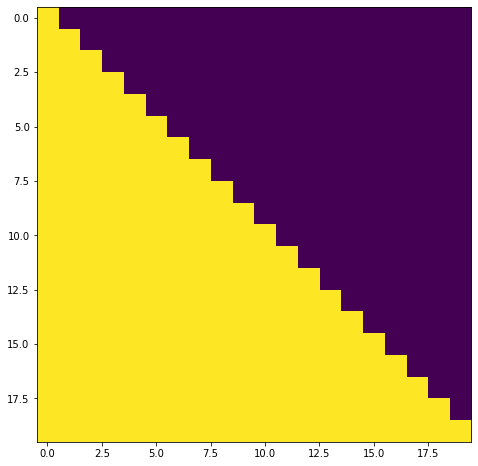

In [152]:
plt.figure(figsize=(8,8))
plt.imshow(subsequent_mask(20)[0])

# Transformer model 
![](./English-to-Chinese.png)  
<u> At each step the model is auto-regressive (cite), consuming the previously generated symbols as additional input when generating the next.</u>

In [176]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        """
        memory - encoder output embedding
        """
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        Take in and process masked src and target sequences
        """
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

# softmax vs log_softmax
$$log(exp(x)/ \sum(exp(x))) = x - log(\sum(exp(x)))$$ 

- The log_softmax is nearly the $x-max(x)$ which is naturally much faster to compute than anything involving logarithms and exponentials. This  also guaranteed that the output won't be of a vastly different scale than the input.

- Another reason is that when softmax is used with log likelihood loss, we use the logarithm of the entries anyway.

In [154]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        # decode: d_model to vocab mapping  - transform embeeding back to human language
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [155]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048,h=8,dropout=.1):
    """
    A full transformer model 
    """
    c = copy.deepcopy # deepcopy for complete copy of object
    # Attention   dim: head-dim, embed dim
    attn = MultiHeadedAttention(h, d_model).to(DEVICE)
    # feedforward
    ff = PositionwiseFeedForward(d_model, d_ff, dropout).to(DEVICE)
    # position encoding
    position = PositionalEncoding(d_model, dropout).to(DEVICE)
    # Transformer
    model = Transformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout).to(DEVICE), N).to(DEVICE),
        nn.Sequential(Embeddings(d_model, src_vocab).to(DEVICE), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab).to(DEVICE), c(position)),
        Generator(d_model, tgt_vocab)
    ).to(DEVICE)

    # model = Transformer(
    #     Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
    #     Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
    #     nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
    #     nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
    #     Generator(d_model, tgt_vocab)
    # ).to(DEVICE)

    # Initialize the parameters with Glorot / fan_avg
    # paper: Understanding the difficulty of training deep feedforward neural networks Xavier
    for p in model.parameters():
        """
        The code snippet ensures that Xavier uniform initialization is applied only to weight 
        matrices (parameters with dimension greater than 1) within the Transformer model, 
        following common initialization practices in deep learning.

        Xavier initialization is typically used for weight matrices (tensors with at least two 
        dimensions) in neural networks.Parameters with a single dimension (like biases) are 
        often initialized differently (e.g., with zeros).
        """
        if p.dim() > 1:
            nn.init.xavier_uniform(p)

    return model.to(DEVICE)

# Model training

- [Smooth loabeling](https://arxiv.org/pdf/1512.00567.pdf) with $\epsilon_{ls}=.1$

# Approach 1
$$y_{ls} = (1-\alpha) * y_{hot} + \alpha / k$$
`y_ls` represents the smoothed label (soft label).
`y_hot` represents the original one-hot encoded label.
`α` is a hyperparameter (between 0 and 1) that controls the amount of smoothing.
`k` is the number of classes in the classification problem.
> A higher `α` value leads to softer labels with more weight distributed to other classes.
> A lower `α` value approaches the original hard labels.

**Benefits of Label Smoothing**
- Reduces Overconfidence: By introducing some noise to the labels, the model is forced to consider alternative class possibilities during training. This can help prevent the model from becoming too reliant on specific features and improve generalization to unseen data.

- Improves Gradient Flow: During backpropagation, the use of soft labels can lead to smoother gradients, which can <u>help the model converge more efficiently and potentially avoid getting stuck in local minima</u>.

# Approach 2
https://sanyamkapoor.com/kb/cross-entropy-label-smoothing-and-focal-loss/

In this case, the KL divergence loss is applied instead of one-hot target distribution, thus, a distribution that has confidence of the correct word and the rest of the smoothing mass distributed throughout the vocabulary.

### Quick review of KL loss
$$D_KL(p || q) = Σ_x p(x) * log( p(x) / q(x) )$$ 
1. **p(x) - the probability of x under the true distributin**
2. **q(x) - the probability of x under the predicted distribution**
3. **log  - the logarithm function often base 2**

> The KL divergence intend to check whether p(x) and q(x) approach toward the same distribution, if they are identical,  the KL loss is 0, meaning the predicted distribution perfectly matches the true distribution, <u>no information is lost</u>.

> On the other hand, when p(x) and q(x) vary, the KL loss will have a relative value which depends on the degree of the difference between p(x) distribution and q(x) distribution.

### KL divergence is not a symmetrical measure. D_KL(p || q) is not the same as D_KL(q || p).

```python
import torch
import torch.nn as nn

# Example hyperparameters
K = 5  # Number of classes
alpha = 0.1  # Smoothing factor

def kl_div_loss(y_pred, y_true):
  """
  KL divergence loss with label smoothing.

  Args:
      y_pred: Predicted probability distribution (e.g., from softmax).
      y_true: One-hot encoded true labels.

  Returns:
      KL divergence loss between predicted and smoothed distributions.
  """
  y_smooth = torch.empty_like(y_pred).fill_(1 / K) + alpha * (y_true - torch.ones_like(y_true))
  return nn.functional.kl_div(y_pred.log(), y_smooth, reduction='sum')

# Example usage
y_pred = torch.tensor([0.9, 0.05, 0.02, 0.01, 0.02])  # Predicted probabilities
y_true = torch.tensor([1, 0, 0, 0, 0])  # One-hot encoded label (class 0)

loss = kl_div_loss(y_pred.unsqueeze(0), y_true.unsqueeze(0))  # Add extra dimension for batch

print(loss)

```

1. **`kl_div_loss` function:** This function takes the predicted probability distribution (`y_pred`) and the one-hot encoded true label (`y_true`) as input.

2. `y_smooth`:

    This calculates the smoothed label distribution.

   - `torch.empty_like(y_pred).fill_(1 / K)` creates a tensor with a uniform distribution (all elements 1/K) with the same size as the prediction.
   - `alpha * (y_true - torch.ones_like(y_true))` adds a scaled difference between the one-hot label and a vector of ones. This ensures the true class has a higher probability but also distributes some probability mass (controlled by `alpha`) to other classes.

3. **KL Divergence Loss:** The function uses `nn.functional.kl_div` to calculate the KL divergence between the logarithm of the predicted distribution (`y_pred.log()`) and the smoothed distribution (`y_smooth`). The `reduction='sum'` argument sums the KL divergence across all elements.


**Mathematical Derivation:**

1. **Notation:**

   - `p(y | x)`: Predicted probability distribution of the model for a given input `x`.
   - `q(y)`: Target probability distribution for the label `y` (smoothed distribution).
   - `D_KL(p(y | x) || q(y))`: KL divergence between `p(y | x)` and `q(y)`.

2. **Loss Function:** The KL divergence loss for label smoothing is:

   ```
   L(x, y) = D_KL(p(y | x) || q(y))
   ```

   Here, the model is trained to minimize this loss function across all training data points.

3. **Target Distribution (q(y))**

   A common approach is to use a uniform distribution:

   ```
   q(y) = 1 / K
   ```

   where `K` is the total number of classes.

**Benefits:**

- Minimizing the KL divergence loss encourages the predicted distribution `p(y | x)` to be closer to the target distribution `q(y)`. This leads to "smoothed" predictions with a higher probability for the true class but also some non-zero probability for other classes.

**Comparison with α-weighted Smoothing:**

- This approach avoids explicit calculation of weighted averages (as in traditional label smoothing with α).
- It offers potential flexibility to explore different target distributions beyond uniform for specific needs.

**In essence:**

The KL divergence loss approach provides a way to implement label smoothing during training. It encourages the model to learn more robust representations by penalizing overly confident predictions. The code demo and mathematical derivation illustrate the concepts involved.

### KL divergence loss of label smoothing
$$  L(x, y) = D_{KL}(p(y | x) || q(y))$$  
- $p(y|x)$ - y_{predict}       
- $q(y)$ - y_{true} (smoothed data)
- 

### Label smoothing cross entropy
$$\tilde{p}(y|x) = \epsilon \cdot \frac{1}{K} + (1-\epsilon) \cdot \delta_{y=k}$$
$$CE(\tilde{p} || q) = - \mathbb E_\tilde p [logq] = \epsilon \cdot CE(U || q) + (1- \epsilon) \cdot CE(p || q)$$

- $CE(U || q)$  - smoothed distribution
- $CE(p||q)$    - y_{predict with cross entropy}

**Conventional KL Divergence Loss:**

- In general machine learning tasks, KL divergence loss is often used to compare:
  - `p(x)`: The true or target distribution you're interested in (e.g., actual class labels in classification).
  - `q(x)`: The predicted probability distribution from your model.
- The loss function minimizes the KL divergence (D_KL(p || q)) between these two distributions. This encourages the model's predictions to get closer to the true distribution.

**Label Smoothing with KL Divergence Loss:**

- Here, the focus is on **smoothing the target distribution** (`q(x)`) itself.

1. **Smoothed Target Distribution:** We define a new target distribution (`q(y)`) that reflects the desired "smoothed" labels.

   - A common approach is to use a uniform distribution across all classes (q(y) = 1/K, where K is the number of classes). This ensures some probability mass is distributed to all classes, not just the true class.

2. **KL Divergence Loss:** We calculate the KL divergence between the predicted probability distribution (`p(y | x)`) from the model and this smoothed target distribution (`q(y)`).

   ```
   L(x, y) = D_KL(p(y | x) || q(y))
   ```

3. **Minimizing the Loss:** The model is trained to minimize this KL divergence loss. By doing so, the predicted distribution (`p(y | x)`) is encouraged to be closer to the smoothed target distribution (`q(y)`). This leads to less overconfident predictions with some probability for other classes besides the true class.

**Key Differences:**

- In the conventional approach, the target distribution (`q(x)`) represents the true labels you want the model to learn.
- In label smoothing, the target distribution (`q(y)`) is intentionally modified to be a smoothed version of the true labels, encouraging the model to be less certain about its predictions.

**In essence:**

Both approaches use KL divergence loss, but label smoothing modifies the target distribution itself to achieve the goal of smoother, less overconfident predictions.

In [156]:
class LabelSmoothing(nn.Module):
    """
    Here, 'size' is from vocab，'smoothing' is value to be distributed on 
    non-groundtruth. We can see an example of how the mass is distributed 
    to the words based on confidence.
    """
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum') # 2020 update
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

# Code comprehension with demo dataset and experiment 

**Demo Data:**

- **Prediction (`x`):** We'll assume a model prediction for a single image with 5 possible classes (size=5). The prediction tensor will be a 1x5 vector representing the probability of each class.

  Python

  ```
  prediction = torch.Tensor([0.2, 0.5, 0.2, 0.1, 0.0])
  ```

- **Target Label (`target`):** We'll set the target class label to be class 2 (index 1).

  Python

  ```
  target = torch.Tensor([1])  # Class 2 (index 1)
  ```

- **Smoothing Factor (`smoothing`):** We'll use a smoothing factor of 0.1.

**Code Breakdown:**

**1. Initialization (`__init__`):**

- We'll skip this part as it focuses on setting up internal variables like the loss function and hyperparameters.

**2. Forward Pass (`forward`):**

**a. Assertion (`assert x.size(1) == self.size`):**

```
 - This line checks if the prediction tensor (`x`) has the correct number of columns (classes) that matches the `size` parameter (5 in this case). It ensures compatibility with the label smoothing logic.
```

**b. `true_dist = x.data.clone()`:**

```
 - We create a copy of the prediction data (`x.data`) and store it in `true_dist`. This tensor will hold the smoothed label distribution. Initially, it's a copy of the raw prediction probabilities.
```

**c. `true_dist.fill_(self.smoothing / (self.size - 2))`:**

```
 - This line fills the `true_dist` tensor with a uniform distribution value based on the smoothing factor (`smoothing`) and class size (`size`).
    - We calculate `smoothing / (size - 2)`. In our example, this would be `0.1 / (5 - 2) = 0.05`.
    - This value represents the probability assigned to each non-ignored class (excluding the padding index) in the initial smoothed distribution.
```

**d. `true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)`:**

```
 - This line is where the `scatter_` method comes into play and incorporates the target label information. Here's a breakdown:
    - **`dim=1`**: This specifies scattering along the column (class) dimension in `true_dist`.
    - **`target.data.unsqueeze(1)`**: This takes the target label tensor (`target`), which is a single element (index 1), and adds a new dimension (becomes a column vector with one row). This ensures it has the same number of rows as `true_dist` for element-wise updates.
    - **`self.confidence`**: This is the value (1-smoothing) that represents the probability mass to be concentrated on the target class. In our example, it's `0.9`.
 - The `scatter_` operation updates the elements in `true_dist` at the indices corresponding to the target class label (index 1 in this case). It replaces the existing value in `true_dist` at index 1 with `self.confidence` (0.9). This increases the probability for the target class in the smoothed distribution.
```

**e. `true_dist[:, self.padding_idx] = 0`:**

```
 - This line sets the elements in `true_dist` corresponding to the padding index (`self.padding_idx`) to zero. Padding elements are typically ignored during training.
```

**f. Handling Padding Index (Optional):**

```
 - The code includes an optional step to handle cases where the target label might contain the padding index. This part isn't crucial for our current example but demonstrates how to deal with padding:
    - It uses `torch.nonzero` to find the indices where the target elements are equal to the padding index.
    - If there are padding elements (`mask.dim() > 0`), it uses `index_fill_` to set the corresponding rows in `true_dist` to zero.
```

**g. Storing `true_dist` and Calculating Loss:**

- The code stores the final smoothed label distribution (`true_dist`) in a class variable (`self.true_dist`). This might be useful for debugging or further analysis within the code.
- It calculates the KL divergence loss between the model's prediction (`x`) and the smoothed label distribution (`true_dist`). It uses the `criterion` (KL divergence loss function) and wraps the `true_dist` in a `Variable` (deprecated in newer PyTorch versions, but the concept remains). This loss value represents the difference between the model's predicted probability distribution and the desired smoothed distribution we created using label smoothing.

**Understanding Dimensions:**

- **`prediction (x)`:** 1x5 tensor (one row, five columns representing probabilities for each class).
- **`target`:** 1x1 tensor (one row, one element representing the target class label).
- **`true_dist`:** 1x5 tensor (same dimensions as prediction, holds the smoothed label distribution).

**Why `unsqueeze` is Used:**

- The `target` label is a single element tensor initially. `unsqueeze(1)` adds a new dimension (becomes a column vector) to ensure it has the same number of rows (1) as the `true_dist` tensor (1x5). This allows for element-wise updates using `scatter_`.

**In Essence:**

This code demonstrates how label smoothing with KL divergence loss works. The `scatter_` method plays a crucial role in updating the elements in the `true_dist` tensor based on the target label and the smoothing factor. This creates a smoothed label distribution that is used to calculate the KL divergence loss, encouraging the model to be less confident about any single class and potentially improve its generalization ability.


## Label Smoothing with KL Divergence (Mathematical Formulation)

Label smoothing with KL divergence introduces a softer target distribution compared to the typical one-hot encoded labels during training. This can improve model robustness and prevent overfitting. Here's the mathematical breakdown:

**1. One-Hot Encoded Label:**

Let `y` be a one-hot encoded label vector for a sample, where `y_i` represents the probability of the sample belonging to class `i`. In a one-hot encoding, only one element (`y_i`) is 1, and all others are 0.

**2. Smoothed Target Distribution:**

Label smoothing introduces a small amount of noise (`smoothing`) into the one-hot encoded labels. This creates a softer target distribution (`q`) where all classes have a non-zero probability.

The smoothed target distribution `q` can be calculated as follows:

```
q_i = (1 - smoothing) * y_i + smoothing / (C - 1)
```

- `C` is the total number of classes.
- `smoothing` is a hyperparameter (typically a small value between 0 and 1) that controls the amount of noise injected.

**3. KL Divergence:**

KL divergence (Kullback-Leibler divergence) measures the difference between two probability distributions. In label smoothing, we use KL divergence to penalize the model when its predicted distribution (`p(x)`) deviates from the smoothed target distribution (`q`).

The KL divergence between the predicted distribution `p(x)` and the smoothed target distribution `q` can be expressed as:

```
D_KL(q || p(x)) = sum( q_i * log(q_i / p_i(x)) )
```

- `i` iterates over all classes.
- `q_i` is the probability of class `i` in the smoothed target distribution.
- `p_i(x)` is the probability of class `i` predicted by the model for the current sample `x`.

**4. Loss Function:**

During training, the model aims to minimize the overall loss function. In label smoothing with KL divergence, the loss function incorporates the KL divergence term:

```
Loss = CrossEntropy(p(x), y) + λ * D_KL(q || p(x))
```

- `CrossEntropy(p(x), y)` is the traditional cross-entropy loss between the model's prediction `p(x)` and the one-hot encoded label `y`.
- λ is a hyperparameter that controls the weight of the KL divergence term in the overall loss.

By minimizing this combined loss function, the model is encouraged to make predictions that are close to both the original one-hot labels (through cross-entropy) and the smoothed target distribution (through KL divergence).

**Key Points:**

- Label smoothing with KL divergence injects noise into the one-hot labels and uses KL divergence to guide the model towards a smoother target distribution.
- The hyperparameters `smoothing` and λ control the amount of noise and the influence of the KL divergence term, respectively.

**Note:**

The code snippet you provided implements label smoothing using the KL divergence formulation. It calculates the smoothed target distribution (`true_dist`) and then uses the `nn.KLDivLoss` function to compute the KL divergence between the model's prediction and the smoothed target distribution.

# gather and scatter function
- gather
  https://www.cnblogs.com/HongjianChen/p/9451526.html
  https://zhuanlan.zhihu.com/p/352877584
  https://blog.csdn.net/m0_51312071/article/details/134156689
- scatter 
  https://zhuanlan.zhihu.com/p/371889735
  https://zhuanlan.zhihu.com/p/187401278

# Gather demo

In [157]:
input = torch.tensor([[1, 2, 3],
                      [4, 5, 6],
                      [7, 8, 9]])

In [158]:
index = torch.tensor([[0, 2],
                      [1, 0],
                      [2, 1]])

- Gatehr from dim 0 means to align with rows  
  **For each value in the index tensor**
  1. Check the index value, then find the index of index value
  2. for example, [0,2], 0 goes first, the index of 0 is 0, then the first value we are looking for would be located at [0,0], i.e. 1; 2 goes second, the index of 2 in that row is 1, then the second value we are looking for would become [2,1], i.e. 8. so on so forth

In [159]:
output1 = torch.gather(input, dim=0, index=index)
output1

tensor([[1, 8],
        [4, 2],
        [7, 5]])

- Gatehr from dim 0 means to align with cols  
  **For each value in the index tensor**
  1. Check the row index of each value, then use the value as col index
  2. For example, [0,2], the [0,2] is located at the row 0, then the row index starts form 0, the col index is the current index value itself, which is 0, then the first number should be chosen by [0,0], which is 1. Then it is still row 0, and current index value as the col index, which is 2, so [0,2], which is 3, therefore, [1,3].
  3. To make it further clearer, for the second row, the index is now 1, the current index value is 1, then [1,1], which is 5, continue to push, [1, 0]. which is 4, second row of result is [5,4]
  4. [22, 21] -> [9,8]

In [160]:
output1 = torch.gather(input, dim=1, index=index)
output1

tensor([[1, 3],
        [5, 4],
        [9, 8]])

# Scatter demo
> Scatter is the reverse operation of gatehr

In [161]:
# gather
t = torch.tensor([[1,2],[3,4]])
t

tensor([[1, 2],
        [3, 4]])

In [162]:
torch.gather(t, 1, torch.tensor([[0,0],[1,0]]))

tensor([[1, 1],
        [4, 3]])

In [163]:
# scatter_
x = torch.rand(2, 5)
x

tensor([[0.4926, 0.3394, 0.5499, 0.4510, 0.2141],
        [0.2179, 0.9339, 0.5210, 0.9790, 0.0958]])

In [164]:
torch.zeros(3, 5).scatter_(0, torch.tensor([[0, 1, 2, 0, 0], [2, 0, 0, 1, 2]]), x)

tensor([[0.4926, 0.9339, 0.5210, 0.4510, 0.2141],
        [0.0000, 0.3394, 0.0000, 0.9790, 0.0000],
        [0.2179, 0.0000, 0.5499, 0.0000, 0.0958]])

In [165]:
t = torch.tensor([[0.4043, 0.8354, 0.7379, 0.8713, 0.0514],
        [0.0000, 0.5087, 0.0000, 0.0730, 0.0000],
        [0.2242, 0.0000, 0.8726, 0.0000, 0.1186]])
t

tensor([[0.4043, 0.8354, 0.7379, 0.8713, 0.0514],
        [0.0000, 0.5087, 0.0000, 0.0730, 0.0000],
        [0.2242, 0.0000, 0.8726, 0.0000, 0.1186]])

In [166]:
torch.gather(t, 0, torch.tensor([[0, 1, 2, 0, 0], [2, 0, 0, 1, 2]]))

tensor([[0.4043, 0.5087, 0.8726, 0.8713, 0.0514],
        [0.2242, 0.8354, 0.7379, 0.0730, 0.1186]])

The `LabelSmoothing` class you provided doesn't directly get a target distribution in the traditional sense. Instead, it creates a **smoothed target distribution** based on the ground truth labels (`target`) and a smoothing factor. Here's a breakdown of how it achieves this:

**1. Initial Uniform Distribution:**

- The code first creates a tensor named `true_dist` with the same size as the model's prediction (`x`).
- This `true_dist` tensor is initially filled with a value of `smoothing / (size - 2)`. Here's what this means:
    - `smoothing` is a hyperparameter (between 0 and 1) that controls the strength of smoothing. A higher `smoothing` value leads to a more uniform distribution.
    - `size` is the number of classes in your classification problem.

- This initial filling essentially creates a uniform distribution across all classes in `true_dist`, except for the true label, which will be emphasized later.

**2. Emphasizing the True Label with `scatter_`:**

- The `scatter_` function plays a crucial role in transforming this initial uniform distribution into a smoothed target distribution.
- Here's how it works:
    - It takes three arguments:
        - The target tensor (`true_dist`) where the update will occur.
        - The dimension along which to scatter (dimension 1 for rows in this case).
        - The values to scatter (a tensor containing the confidence for the true label).

- The code uses `scatter_(1, target.data.unsqueeze(1), self.confidence)`. Let's break down this line:
    - `target.data.unsqueeze(1)`: This takes the ground truth labels (`target`) and adds a new dimension of size 1 at index 1 (creating a column vector).
    - `self.confidence`: This is `1.0 - smoothing`, representing the probability mass assigned to the true label.

- Essentially, `scatter_` goes through each row in `target` (representing a sample) and updates the corresponding element in `true_dist` (at the same index) based on the true label and its confidence value.

**Example:**

- Assume `target` contains a label `2` for a specific sample.
- `scatter_` will locate the row in `true_dist` corresponding to that sample.
- It will then update the element at index 2 (assuming there are 3 classes) in that row of `true_dist` to the confidence value (e.g., 0.9 if `smoothing` is 0.1).

**Result:**

By applying `scatter_` for all samples in `target`, the `true_dist` tensor gets transformed from a uniform distribution to one where the true label for each sample has a higher probability compared to other classes.

**3. Handling Padding:**

- The code might have a `padding_idx` defined, which represents a class used for padding sequences.
- It sets the probability for this padding class (index) in `true_dist` to 0 using `true_dist[:, self.padding_idx] = 0`. Padding elements are typically ignored during loss calculation.

**Key Points:**

- The `scatter_` method doesn't directly get a target distribution; it manipulates an initially uniform distribution to emphasize the true labels.
- The smoothing factor (`smoothing`) controls the balance between emphasizing the true label and maintaining some probability for other classes.

I hope this explanation clarifies how the `scatter_` method is used to create a smoothed target distribution within the `LabelSmoothing` class.

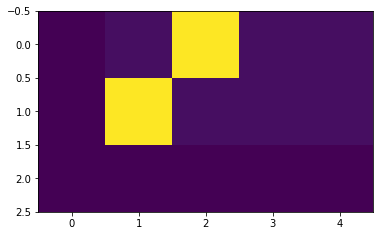

In [167]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.1)  #  ϵ=0.4
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

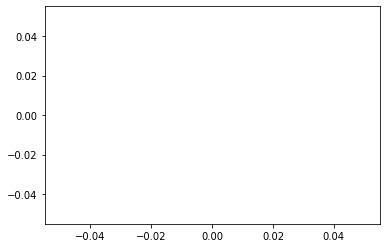

In [168]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(Variable(predict.log()), Variable(torch.LongTensor([1]))).item()

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

In [169]:
class SimpleLossCompute:
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm.float()

In [170]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
# We used factor=2, warmup-step = 4000
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

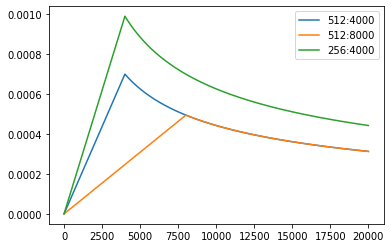

In [171]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [172]:
# train iterator
def run_epoch(data, model, loss_compute, epoch):
    start = time.time()
    total_tokens = 0.
    total_loss = 0.
    tokens = 0.
    for i , batch in enumerate(data):
        out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch {:d} Batch: {:d} Loss: {:.4f} Tokens per Sec: {:.2f}s".format(epoch, i - 1, loss / batch.ntokens, (tokens.float() / elapsed / 1000.)))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

def train(data, model, criterion, optimizer):
    """
    Train and Save the model.
    """
    # init loss as a large value
    best_dev_loss = 1e5
    
    for epoch in range(EPOCHS):
        # Train model 
        model.train()
        run_epoch(data.train_data, model, SimpleLossCompute(model.generator, criterion, optimizer), epoch)
        model.eval()

        # validate model on dev dataset
        print('>>>>> Evaluate')
        dev_loss = run_epoch(data.dev_data, model, SimpleLossCompute(model.generator, criterion, None), epoch)
        print('<<<<< Evaluate loss: {:.2f}'.format(dev_loss))
        
        # save the model with best-dev-loss
        if dev_loss < best_dev_loss:
            best_dev_loss = dev_loss
            torch.save(model.state_dict(), SAVE_FILE) # SAVE_FILE = 'save/model.pt'
            
        print(f">>>>> current best loss: {best_dev_loss}")

# training process

In [192]:
# Step 1: Data Preprocessing
data = PrepareData(TRAIN_FILE, DEV_FILE)
src_vocab = len(data.en_word_dict)
tgt_vocab = len(data.cn_word_dict)
print(f"src_vocab {src_vocab}")
print(f"tgt_vocab {tgt_vocab}")

# Step 2: Init model
model = make_model(
                    src_vocab, 
                    tgt_vocab, 
                    LAYERS, 
                    D_MODEL, 
                    D_FF,
                    H_NUM,
                    DROPOUT
                )

# Step 3: Training model
print(">>>>>>> start train")
train_start = time.time()
criterion = LabelSmoothing(tgt_vocab, padding_idx = 0, smoothing= 0.0)
optimizer = NoamOpt(D_MODEL, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9,0.98), eps=1e-9))

train(data, model, criterion, optimizer)
print(f"<<<<<<< finished train, cost {time.time()-train_start:.4f} seconds")

src_vocab 5493
tgt_vocab 3194
>>>>>>> start train


/tmp/ipykernel_2755151/1099460055.py:42: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


Epoch 0 Batch: 0 Loss: 8.1740 Tokens per Sec: 7.44s
Epoch 0 Batch: 50 Loss: 7.0568 Tokens per Sec: 8.03s
Epoch 0 Batch: 100 Loss: 6.1523 Tokens per Sec: 8.38s
Epoch 0 Batch: 150 Loss: 5.6043 Tokens per Sec: 8.03s
Epoch 0 Batch: 200 Loss: 5.1455 Tokens per Sec: 8.12s
>>>>> Evaluate
Epoch 0 Batch: 0 Loss: 5.1567 Tokens per Sec: 9.50s
<<<<< Evaluate loss: 5.15
>>>>> current best loss: 5.146417617797852
Epoch 1 Batch: 0 Loss: 5.4114 Tokens per Sec: 7.50s
Epoch 1 Batch: 50 Loss: 4.7752 Tokens per Sec: 7.65s
Epoch 1 Batch: 100 Loss: 4.4078 Tokens per Sec: 8.32s
Epoch 1 Batch: 150 Loss: 4.8459 Tokens per Sec: 7.74s
Epoch 1 Batch: 200 Loss: 4.5031 Tokens per Sec: 8.11s
>>>>> Evaluate
Epoch 1 Batch: 0 Loss: 4.5550 Tokens per Sec: 9.91s
<<<<< Evaluate loss: 4.58
>>>>> current best loss: 4.575903415679932
Epoch 2 Batch: 0 Loss: 5.0273 Tokens per Sec: 7.45s
Epoch 2 Batch: 50 Loss: 4.2001 Tokens per Sec: 8.04s
Epoch 2 Batch: 100 Loss: 3.8721 Tokens per Sec: 8.45s
Epoch 2 Batch: 150 Loss: 4.2797 Tok

Epoch 20 Batch: 100 Loss: 0.9297 Tokens per Sec: 8.75s
Epoch 20 Batch: 150 Loss: 1.2775 Tokens per Sec: 8.26s
Epoch 20 Batch: 200 Loss: 1.1420 Tokens per Sec: 8.38s
>>>>> Evaluate
Epoch 20 Batch: 0 Loss: 1.4563 Tokens per Sec: 9.84s
<<<<< Evaluate loss: 1.30
>>>>> current best loss: 1.2994567155838013
Epoch 21 Batch: 0 Loss: 1.8562 Tokens per Sec: 7.82s
Epoch 21 Batch: 50 Loss: 1.1027 Tokens per Sec: 8.09s
Epoch 21 Batch: 100 Loss: 0.9095 Tokens per Sec: 8.68s
Epoch 21 Batch: 150 Loss: 1.3161 Tokens per Sec: 8.16s
Epoch 21 Batch: 200 Loss: 1.0985 Tokens per Sec: 8.34s
>>>>> Evaluate
Epoch 21 Batch: 0 Loss: 1.3898 Tokens per Sec: 9.30s
<<<<< Evaluate loss: 1.26
>>>>> current best loss: 1.2566848993301392
Epoch 22 Batch: 0 Loss: 1.7957 Tokens per Sec: 7.57s
Epoch 22 Batch: 50 Loss: 1.0403 Tokens per Sec: 8.09s
Epoch 22 Batch: 100 Loss: 0.9221 Tokens per Sec: 8.68s
Epoch 22 Batch: 150 Loss: 1.2809 Tokens per Sec: 8.17s
Epoch 22 Batch: 200 Loss: 1.0786 Tokens per Sec: 7.96s
>>>>> Evaluate


Epoch 40 Batch: 100 Loss: 0.5976 Tokens per Sec: 8.49s
Epoch 40 Batch: 150 Loss: 0.8160 Tokens per Sec: 7.58s
Epoch 40 Batch: 200 Loss: 0.6446 Tokens per Sec: 7.93s
>>>>> Evaluate
Epoch 40 Batch: 0 Loss: 0.7130 Tokens per Sec: 9.40s
<<<<< Evaluate loss: 0.63
>>>>> current best loss: 0.6335633993148804
Epoch 41 Batch: 0 Loss: 1.1636 Tokens per Sec: 7.34s
Epoch 41 Batch: 50 Loss: 0.6384 Tokens per Sec: 8.24s
Epoch 41 Batch: 100 Loss: 0.5067 Tokens per Sec: 8.46s
Epoch 41 Batch: 150 Loss: 0.7727 Tokens per Sec: 7.81s
Epoch 41 Batch: 200 Loss: 0.6076 Tokens per Sec: 7.91s
>>>>> Evaluate
Epoch 41 Batch: 0 Loss: 0.7161 Tokens per Sec: 9.83s
<<<<< Evaluate loss: 0.61
>>>>> current best loss: 0.6138356328010559
Epoch 42 Batch: 0 Loss: 1.1870 Tokens per Sec: 7.46s
Epoch 42 Batch: 50 Loss: 0.6534 Tokens per Sec: 8.07s
Epoch 42 Batch: 100 Loss: 0.4981 Tokens per Sec: 8.29s
Epoch 42 Batch: 150 Loss: 0.6703 Tokens per Sec: 8.22s
Epoch 42 Batch: 200 Loss: 0.5747 Tokens per Sec: 8.32s
>>>>> Evaluate


# Prediction with the trained model

In [193]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    Translate src with model
    """
    # decode the src 
    memory = model.encode(src, src_mask)
    # init 1×1 tensor as prediction，fill in ('BOS')id, type: (LongTensor)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    #  run 遍历输出的长度下标
    for i in range(max_len-1):
        # decode one by one
        out = model.decode(memory, 
                           src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        #  out to log_softmax 
        prob = model.generator(out[:, -1])
        #  get the max-prob id
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        #  concatnate with early predictions
        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [194]:
def evaluate(data, model):
    """
    Make prediction with trained model, and print results.
    """
    with torch.no_grad():
        #  pick some random sentences from dev data.         
        for i in np.random.randint(len(data.dev_en), size=10):
            # Print English sentence
            en_sent = " ".join([data.en_index_dict[w] for w in data.dev_en[i]])
            print("\n" + en_sent)
            
            # Print Target Chinese sentence
            cn_sent =  " ".join([data.cn_index_dict[w] for w in data.dev_cn[i]])
            print("".join(cn_sent))
            
            # conver English to tensor  
            src = torch.from_numpy(np.array(data.dev_en[i])).long().to(DEVICE)
            src = src.unsqueeze(0)
            # set attention mask
            src_mask = (src != 0).unsqueeze(-2)
            # apply model to decode, make prediction
            out = greedy_decode(model, src, src_mask, max_len=MAX_LENGTH, start_symbol=data.cn_word_dict["BOS"])
            # save all in the translation list 
            translation = []
            # convert id to Chinese, skip 'BOS' 0.
            # 遍历翻译输出字符的下标（注意：跳过开始符"BOS"的索引 0）
            for j in range(1, out.size(1)):
                sym = data.cn_index_dict[out[0, j].item()]
                if sym != 'EOS':
                    translation.append(sym)
                else:
                    break
            print("translation: {}".format(" ".join(translation)))

In [195]:
# Predition
model.load_state_dict(torch.load(SAVE_FILE))
print(">>>>>>> start evaluate")
evaluate_start  = time.time()
evaluate(data, model)         
print(f"<<<<<<< finished evaluate, cost {time.time()-evaluate_start:.4f} seconds")

>>>>>>> start evaluate

BOS my gums are UNK . EOS
BOS 我 的 牙 齦 流 血 。 EOS
translation: 我 的 牙 齦 流 血 。

BOS there was UNK any money left . EOS
BOS 几 乎 没 剩 下 钱 。 EOS
translation: 有 钱 被 偷 了 钱 。

BOS i invited my friends to dinner . EOS
BOS 我 邀 請 我 的 朋 友 吃 晚 餐 。 EOS
translation: 我 邀 請 了 我 的 朋 友 吃 晚 餐 。

BOS i am not a student . EOS
BOS 我 不 是 學 生 。 EOS
translation: 我 不 是 學 生 。

BOS someone has taken my shoes by mistake . EOS
BOS 有 人 拿 错 了 我 的 鞋 。 EOS
translation: 有 人 穿 错 了 我 的 鞋 。

BOS you should get your hair cut . EOS
BOS 你 该 剪 头 发 了 。 EOS
translation: 你 應 該 剪 頭 髮 。

BOS she is very thoughtful and patient . EOS
BOS 她 非 常 周 到 和 耐 心 。 EOS
translation: 她 非 常 周 到 和 耐 心 。

BOS wait just a moment . EOS
BOS 就 等 一 會 兒 。 EOS
translation: 等 一 會 兒 。

BOS please do n't ask . EOS
BOS 請 不 要 問 。 EOS
translation: 請 不 要 問 。

BOS i will go on ahead . EOS
BOS 我 會 繼 續 前 進 。 EOS
translation: 我 會 繼 續 前 地 前 進 。
<<<<<<< finished evaluate, cost 7.9781 seconds


In [197]:
# Here is my pretrained model with CUDA support 
if DEVICE=="cuda":
    SAVE_FILE_EXTRA  = 'save/models/large_model.pt'  
    model.load_state_dict(torch.load(SAVE_FILE_EXTRA))
    print(">>>>>>> start evaluate")
    evaluate_start  = time.time()
    evaluate(data, model)         
    print(f"<<<<<<< finished evaluate, cost {time.time()-evaluate_start:.4f} seconds")

device(type='cuda')